# CHAPTER 3. 분류

1장에서는 가장 일반적인 지도 학습 작업이 회귀와 분류라고 배웠다. 

2장에서는 주택 가격을 예측하는 회귀 작업을 살펴보며 선형 회귀, 결정 트리, 랜덤 포레스트 같은 여러 알고리즘을 보았다.

이 장에서는 분류 시스템을 집중적으로 다룬다.

# 1. MNIST

이 장에서는 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 MNIST 데이터셋을 사용한다. 사이킷런의 `fetch_openml` 기능은 deprecated 되어 수동으로 데이터를 다운받아야 한다.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from uidam_package import download

dataset_name = "mnist"
data_dict = {
'X_train' : "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
'y_train' : "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
'X_test' : "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
'y_test' : "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
}

download.downloadAndUnzipFile(dataset_name, data_dict, False)

Download Start...
...File Already Exists. Use overwrite=True to overwrite.
Download Completed...
Unzip Start...
...File Already Exists. Use overwrite=True to overwrite.
Unzip Completed...


In [4]:
from uidam_package import fetchData

X_train, y_train, X_test, y_test = fetchData.fetch_mnist()

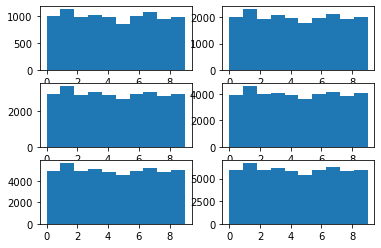

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2)
ax = ax.ravel()

for idx, axis in enumerate(ax):
    axis.hist(y_train[:(idx+1)*10000])
plt.show()

이미지가 70,000개 있고, 각 이미지에는 784개의 특성이 있다. (이 데이터는 이미 28x28로 변형된 데이터이다! 따라서 784로 줄여준다.) 

개개의 특성은 0(흰색) 부터 255(검은색) 까지의 픽셀 강도를 나타낸다.

In [6]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [7]:
X_train.shape

(60000, 784)

In [8]:
X_test.shape

(10000, 784)

In [9]:
y_train.shape

(60000,)

In [10]:
y_test.shape

(10000,)

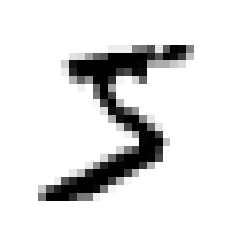

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(X_train[0].reshape((28, 28)), cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

숫자 9처럼 보이는데, 실제로 확인해보자.

In [12]:
# 실제 값도 5이다!
y_train[0]

5

MNIST 데이터는 원래 앞쪽 60,000개를 훈련 세트, 뒤쪽 10,000개를 테스트 세트로 만들어 두었다. 이제 훈련 세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 만들자.

특정 학습 알고리즘들은 훈련 샘플의 순서에 민감해 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠진다. 

데이터셋을 섞어 이런 문제를 방지할 수 있다.

---

**Warning.**

시계열 데이터와 같이 데이터의 순서와 흐름이 있는 경우, 데이터를 섞어서는 안 된다!

---

In [13]:
import numpy as np

shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

실제로 보면 잘 섞여 있다.

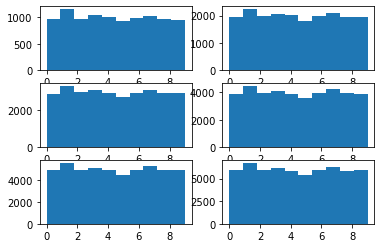

In [14]:
fig, ax = plt.subplots(3, 2)
ax = ax.ravel()

for idx, axis in enumerate(ax):
    axis.hist(y_train[:(idx+1)*10000])
plt.show()

# 2. 이진 분류기 훈련

문제를 단순화하여 하나의 숫자만 식별해본다고 하자. 

예를 들어, '5'라는 숫자만 식별을 한다고 가정할 때, 5-감지기는 '5'와 '5 아님' 두 개의 클래스를 분류할 수 있는 **이진 분류기 binary classifier**의 한 예가 된다.

In [15]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

분류 모델을 하나 선택해서 훈련시켜보자. 사이킷런의 `SGDClassifier` 클래스를 사용해 **확률적 경사 하강법 Stochastic Gradient Descent** 분류기로 시작해보자.

이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있다. SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다.

(그래서 **SGD는 온라인 학습에 잘 맞다.**)

In [16]:
X_train.shape

(60000, 784)

In [17]:
from sklearn.linear_model import SGDClassifier

#SGD는 훈련하는 데 무작위성을 사용하기 때문에 random_state 변수가 쓰인다.
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [18]:
# 이 경우, 특별하게 정확히 맞춘 것 같으므로, 모델의 성능을 평가해보자.
print(sgd_clf.predict([X_train[-2]]))
print(y_train_5[-2])

[False]
False


# 3. 성능 측정

분류기 평가는 회귀 모델보다 훨씬 어렵기 때문에 이 주제를 심층적으로 다룰 것이다.

사용할 수 있는 성능 지표가 많기 때문이다.

## 3.1 교차 검증을 사용한 정확도 측정

2장에서 한 것처럼 교차 검증은 모델을 평가하는 좋은 방법이다.



---

**Tip. 교차 검증 구현**

가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다.

이때는 직접 구현하면 된다. 다음 코드는 사이킷런의 `cross_val_score()` 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다.


In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 교차검증을 세 폴드로 나눈다. (= 60000/3 = 20000개씩 Fold를 만들어, 3번 검증한다.)
# StratifiedKFold는 클래스별 비율이 유지되도록 계층적 샘플링을 수행한다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#split은 각 회차를 반환하는데, 각 회차마다 train셋과 test셋의 인덱스를 반환한다.
#주의할 점은, 여기서 test셋이 처음에 나눈 1만 개의 테스트 셋이 아니라는 점이다!
#여기서는 train셋 안에서 나뉘어진, 또 다른 test set을 의미함.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    #sklearn.base의 clone 함수는 해당 모델의 파라미터를 그대로 가져온다. 단, 데이터가 학습된 상태가 아닌, 모델과 파라미터만을 가져온다.
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96075
0.95555
0.96355


---

이번에는 `cross_val_score()` 함수로 같은 모델을 평가해보자.

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95925, 0.96375, 0.9453 ])

이 역시 모든 교차 검증 폴드에 대해 **정확도(정확한 예측의 비율)**가 95% 이상이다!

이제 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return  np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9105 , 0.90855, 0.9099 ])

여기서도 정확도는 90% 이상이다. 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님' 으로 예측해도 정확도가 90% 이상이 되는 것이다.

이 예제는 **정확도를 분류기의 성능 측정 지표로** 선호하지 않는 이유를 보여준다.

특히 불균형한 데이터셋을 다룰 때는 더더욱 그렇다.

# 3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 **오차 행렬 Confusion Matrix**을 조사하는 것이다. 

기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것이다. 예를 들어, 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

**행은 실제 클래스, 열은 예측한 클래스!**

일단 예측값을 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 된다. `cross_val_predict()` 함수를 사용해보자.

이 함수는 평가 점수를 반환하지 않고 테스트 폴드에서 얻은 예측을 반환한다. 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 되는데, 이는 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미이다.

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53167,  1412],
       [ 1222,  4199]], dtype=int64)

오차 행렬의 행은 **실제 클래스**를 나타내고, 열은 **예측한 클래스**를 나타낸다. 

여기서 첫 번째 행렬은 '5 아님'에 해당하는 **음성 클래스 negative class**이고, 53920개를 '5 아님'으로 정확하게 분류 (**진짜 음성 True Negative**)하였고, 

나머지 659개는 '5'라고 잘못 분류했다. (**거짓 양성 False Positive**)

두 번째 행은 '5'에 해당하는 **양성 클래스 Positive Class**이고, 1661개를 '5 아님'으로 잘못 분류 (**거짓 음성 False Negative**),

나머지 3760개를 정확히 '5'라고 분류했다. (**진짜 양성 True Positive**)

완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

 ## 3.3 정밀도와 재현율

분류기의 지표 중 하나인 **정밀도 Precision**을 알아보자.

$ 정밀도 = \frac{TP}{TP+FP}$

TP는 진짜 양성의 수이고, FP는 거짓 양성의 수이다. 정밀도는 **재현율 Recall**이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.

재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로, **민감도 Sensitivity**또는 **진짜 양성 비율 True Positive Rate, TPR** 이라고도 한다.

$ 재현율 = \frac{TP}{TP+FN}$

--- 

**Tip. 쉽게 이해하기**

True가 붙으면, 실제 클래스를 정확하게 예측한 것이다. TP든 TN이든 (실제,예측)이 (양성, 양성)이거나 (음성, 음성)이다.

False가 붙으면, 실제 클래스를 잘못 예측한 것이다. FP든 FN이든 뒤에 붙은 P, N이 예측값이고, 예측을 잘못 했으므로 실제 데이터의 라벨은 그 반대인 N, P가 된다!

그래서, 

- **양성 예측의 정확도인 정밀도**는 양성이라고 **예측**한 것들(TP, FP) 중, 맞은 것(TP)이 되고,

- **정확하게 감지한 양성 샘플의 비율인 재현율**은 실제 양성인 것들(TP, FN) 중, 제대로 예측한 것(TP)이 된다.

---

사이킷런은 이러한 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.74835145250401

In [25]:
recall_score(y_train_5, y_train_pred)

0.7745803357314148

이제 다시 '5-판별기'를 해석해보면 그리 매력적이지는 않다. 

5로 판별된 이미지 중 (= 양성으로 예측한 이미지 중), 85%만 정확하다.

또한 전체 숫자 5에서 (= 실제 5인 이미지 중), 69%만을 감지했다.

보통 정밀도와 재현율을 **F1점수, F1 Score**라고 하는데, 이는 두 분류기를 비교할 때 자주 쓰인다.

F1점수는 정밀도와 재현율의 **조화 평균 Harmonic Mean**이다.

$$ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 * \frac{정밀도*재현율}{정밀도+재현율} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

일반화된 F점수의 조화 평균 식은 아래와 같다. 알파가 0.5보다 작으면 재현율이 강조되고, 크면 정밀도가 강조된다.

$$ F_1 = \frac{1}{\frac{\alpha}{정밀도} + \frac{1-\alpha}{재현율}} $$

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7612400290065265

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높게 나온다. 하지만 이게 항상 바람직한 것은 아니다.

---

**Warning. F1 점수**

어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정해보자. 

재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 안전한 것들만 노출시키는 분류기가 선호될 것이다.

다른 예로, CCTV를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정해보자.

분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모른다. (아마 경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것이다.)

---

# 3.4 정밀도/재현율 트레이드오프

아쉽지만 이 둘을 모두 얻을 수는 없다.

정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지이다. 이를 **정밀도/재현율 트레이드오프**라고 한다.

`SGDClassifier`가 분류를 어떻게 하는지 살펴보며 트레이드오프를 이해해보자.

이 분류기는 **결정 함수 Decision Function**를 사용하여 각 샘플의 점수를 계산한다. 

이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고, 그렇지 않으면 음성에 할당한다.

In [27]:
# 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([-425851.21877772])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

`SGDClassifier`의 임곗값이 0이므로 위 코드는 `predict()` 메서드와 같은 결과를 반환한다.

그렇다면 적절한 임곗값을 어떻게 정할까? `cross_val_predict()` 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.

그리고 맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그려보자.

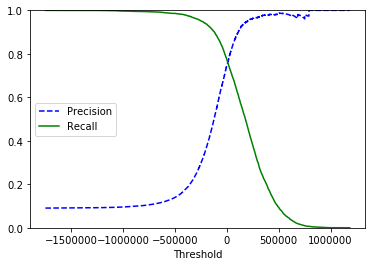

In [29]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

이제 작업에 맞는 최선의 정밀도/재현율 트레이드오프를 만드는 임곗값을 선택하면 된다.

이는 재현율에 대한 정밀도 곡선을 그리면 좋은 정밀도/재현율 트레이드오프를 선택하는 데 도움이 된다.

또한 `average_precision_score` 함수를 사용하면 아래 면적을 계산할 수 있어 서로 다른 두 모델 비교에 좋다.

0.8350946740269225


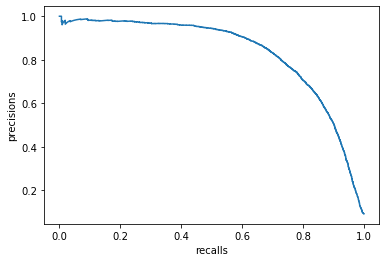

In [30]:
from sklearn.metrics import average_precision_score


def plot_recall_precision(precisions, recalls):
    area = average_precision_score(y_train_5, y_scores)
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("recalls")
    plt.ylabel("precisions")
    print(area)
    
plot_recall_precision(precisions, recalls)
plt.show()

재현율 80% 근처에서 정밀도는 급격하게 떨어지기 시작한다. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

여기서는 정밀도 90%를 달성하는 것이 목표라고 가정해보자. 위 그래프를 통해 임곗값이 약 110,000 정도라는 것을 알 수 있다.

훈련 세트에 대한 예측을 만들려면 분류기의 `predict()` 메서드는 호출하는 대신 다음 코드를 실행하면 된다.

In [31]:
# y_scores에는 decision_function 값들이 들어있기 때문에
y_train_pred_90 = (y_scores > 110000)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9011976047904192
0.6107729201254382


정밀도 90%에 근접한 분류기를 만들었지만, 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않을 것이다.

***누군가 99% 정밀도를 달성하자!라고 말하면 반드시 '재현율 얼마에서?'라고 물어봐야 한다.***

# 3.5 ROC 곡선 (Receiver Operating Characteristic)

**수신기 조작 특성 Receiver Operating Characteristic** 곡선도 이진 분류에서 널리 사용하는 도구이다.

정밀도/재현율 곡선과 매우 비슷하지만, ROC 곡선은 **거짓 양성 비율 False Positive Rate, FPR**에 대한 **진짜 양성 비율 True Positive Rate, TPR**의 곡선이다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR이다. 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율을 뺀 값이다.

TNR을 **특이도 Specificity**라고도 하기 때문에, ROC 곡선은 **민감도(재현율)에 대한 1 - 특이도 그래프**이다.

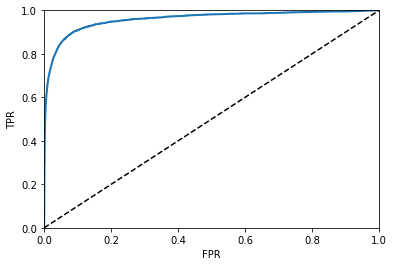

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    
plot_roc_curve(fpr, tpr)
plt.show()

여기에서도 트레이드오프를 찾을 수 있다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.

점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다. 좋은 분류기는 이 점선으로부터 최대한 멀리 떨어져 있어야 한다. (왼쪽 위 모서리로)

**곡선 아래의 면적 Area Under the Curve, AUC** 을 측정하면 분류기들을 비교할 수 있다.

완벽한 분류기는 ROCAUC가 1이 되고, 완전한 랜덤 분류기는 0.5가 된다.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9594296107537227

---

**Tip. 어떤 지표를 쓸까?**

ROC 곡선이 정밀도/재현율 곡선과 비슷해서 어떤 것을 사용해야 할지 궁금할 수 있다. 

일반적으로 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고, 그렇지 않으면 ROC 곡선을 사용한다.

예를 들어, 위 ROC 곡선은 매우 좋은 분류기라고 판단될 수 있지만, 이는 음성에 비해 양성(5)이 크게 적기 때문이다. 

이와 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지(오른쪽 위 모서리에 가까워질 수 있는지) 잘 보여준다.

---

이번에는 `RandomForestClassifier`를 `SGDClassifier`와 비교해보자. 

알고리즘의 차이 때문에 `decision_function()` 메서드가 없고, `predict_proba()` 메서드가 존재한다.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from uidam_package import model

if(model.model_exists("chap3_forest_cv.pkl")):
    y_probas_forest = model.get_model("chap3_forest_cv.pkl")
else:
    forest_clf = RandomForestClassifier(random_state=42)
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
    model.save_model(y_probas_forest, "chap3_forest_cv.pkl")

model loaded...


하지만 ROC 곡선을 그리려면 확률이 아니라 점수가 필요한데, 간단히 양성 클래스의 확률을 점수로 사용할 수 있다.

In [35]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

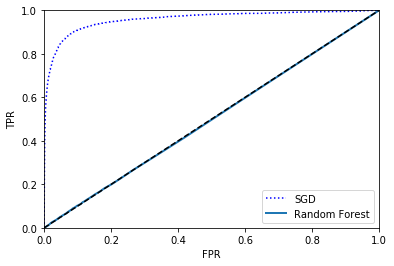

In [36]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

`RandomForestClassifier`의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 좋아 보인다. 당연하게 ROCAUC 값도 더 높다.

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.4989888761607824

In [38]:
# 양성 클래스의 확률이 0.5보다 큰 경우 = True이면 1이고 False이면 0이다.
# 즉, 자연스레 양성, 음성 클래스의 라벨이 1, 0으로 변환됨
y_train_proba_predict = y_scores_forest > 0.5

# 이 상태에서 정밀도와 재현율을 구한다.
print(precision_score(y_train_5, y_train_proba_predict))
print(recall_score(y_train_5, y_train_proba_predict))

0.09206680584551148
0.0813503043718871


각각 98.8%와 87.3%로 나쁘지 않은 결과가 나왔다! 

이제 이진 분류를 훈련시키는 방법과 작업에 맞는 적절한 지표 선택, 교차 검증을 사용한 평가, 트레이드오프, 모델의 비교에 대해 알게 되었다.

이제 숫자 5 이상을 감지해보자.

# 3.4 다중 분류

**다중 분류기 Multiclass Classifier / 다항 분류기 Multinomial Classifier**는 둘 이상의 클래스를 구별할 수 있다.

랜덤 포레스트 분류기나 나이브 베이즈같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면,

서포트 벡터 머신이나 선형 분류기같은 알고리즘은 이진 분류만 가능하다. 하지만 이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법도 많다.

예를 들어,

**일대다 one-versus-all, one-versus-the-rest, OvA 전략**은 이진 분류기 10개(0~9)를 훈려시켜, 클래스가 10개인 이미지 분류 시스템을 만들 수 있다. 

10개의 분류기 중 점수가 가장 높은 것을 클래스로 선택하는 것이다.

**일대일 one-versus-one, OvO 전략**은 0과 1, 0과 2,.. 각 숫자의 조합마다 이진 분류기를 훈련시키는 것이다. 

클래스가 N개라면 분류기는 N(N-1)/2 개가 필요하고, 45개 분류기 모두를 통과시켜 가장 많이 양성으로 분류된 클래스를 선택한다. 이의 장점은 각 분류기의 훈련에 두 클래스에 해당하는 샘플만 필요하다는 점이다.

SVM같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호한다. 하지만 대부분의 이진 알고리즘은 OvA를 선호한다.

사이킷런에서는 이진 분류 알고리즘을 다중 분류 작업에 사용할 경우, 자동으로 OvA (SVM은 OvO)를 적용한다.

In [39]:
sgd_clf.fit(X_train, y_train) #y_train_5가 아닌 y_train 을 사용한다.
sgd_clf.predict([X_train[0]])

array([2])

In [40]:
y_train[0]

2

In [41]:
# 여기서 가장 높은 점수가 1에 해당하는 값이다.
some_digit_scores = sgd_clf.decision_function([X_train[0]])
print(some_digit_scores)
print(sgd_clf.classes_)
print(sgd_clf.classes_[np.argmax(some_digit_scores)])

[[-197190.18949717 -988544.05422179  172498.36932334 -815729.34609272
  -785687.71035785 -415534.87432161 -396071.58559662 -720709.98539895
    60801.49670253 -511172.58145025]]
[0 1 2 3 4 5 6 7 8 9]
2


사이킷런에서 OvO나 OvA를 사용하도록 강제하려면 `OneVsOneClassifier` 또는 `OneVsRestClassifier`를 사용한다.

In [42]:
from sklearn.multiclass import OneVsOneClassifier
from uidam_package import model

model_name = "chap3_ovo_clf.pkl"

if(model.model_exists(model_name)):
    ovo_clf = model.get_model(model_name)
else:
    ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
    ovo_clf.fit(X_train, y_train)
    model.save_model(ovo_clf, model_name)
print(ovo_clf.predict([X_train[0]]))
len(ovo_clf.estimators_) #분류기 개수, 10C2 = 45개

model loaded...
[2]


45

이번에는 `RandomForestClassifier`를 훈련해보자.

이 경우는 다중 클래스로 분류가 가능하기 때문에 OvA나 OvO를 적용할 필요가 없다.

`predict_proba()` 메서드를 호출해 각 샘플의 클래스별 확률을 확인할 수 있다.

In [43]:
model_name = "chap3_forest.pkl"

if(model.model_exists(model_name)):
    forest_clf = model.get_model(model_name)
else:
    forest_clf = RandomForestClassifier(random_state=42)
    forest_clf.fit(X_train, y_train)
    model.save_model(forest_clf, model_name)
forest_clf.predict([X_train[0]])

model loaded...


array([2])

In [44]:
forest_clf.predict_proba([X_train[0]])

array([[0.01, 0.01, 0.93, 0.  , 0.  , 0.  , 0.02, 0.  , 0.02, 0.01]])

이제 분류기를 평가해보자. 분류기 평가에는 일반적으로 교차 검증을 사용한다.

In [45]:
model_name = "chap3_sgd_cv.pkl"

if(model.model_exists(model_name)):
    sgd_cv = model.get_model(model_name)
else:
    sgd_cv = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
    model.save_model(sgd_cv, model_name)
    
sgd_cv

model loaded...


array([0.8444, 0.852 , 0.8731])

모든 테스트 폴드에서 84% 이상을 얻었지만, 아래처럼 성능을 더 높일 여지가 있다.

In [46]:
from sklearn.preprocessing import StandardScaler

model_name = "chap3_pre_sgd_cv.pkl"

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

if(model.model_exists(model_name)):
    pre_sgd_cv = model.get_model(model_name)
else:        
    pre_sgd_cv = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
    model.save_model(pre_sgd_cv, model_name)
pre_sgd_cv

model loaded...


array([0.9065 , 0.91165, 0.9094 ])

# 3.5 에러 분석

실제 프로젝트라면 머신러닝 프로젝트 체크리스트(부록 B)의 단계를 따를 것이다.

데이터 준비 단계에서 가능한 선택사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라 `GridSearchCV`로 하이퍼파라미터를 튜닝하고, 가능한 자동화하는 것이다.

이 절에서는 가능성이 높은 모델을 찾았다고 가정하고 **에러의 종류를 분석하여** 모델의 성능을 향상시킬 방법을 찾아보고자 한다.

### 오차행렬 Confusion Matrix
`cross_val_predict()` 함수를 사용해 예측을 만들고 오차행렬을 호출한다.


In [47]:
pre_sgd_cv

array([0.9065 , 0.91165, 0.9094 ])

In [48]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5722,    5,   18,   12,   11,   55,   46,   11,   39,    4],
       [   2, 6488,   44,   25,    6,   49,    7,    9,   98,   14],
       [  49,   40, 5345,  106,   75,   24,   79,   58,  166,   16],
       [  44,   38,  138, 5360,    3,  226,   33,   56,  138,   95],
       [  22,   27,   32,    8, 5355,    8,   51,   37,   90,  212],
       [  68,   38,   39,  194,   61, 4626,  105,   27,  165,   98],
       [  35,   26,   44,    2,   41,  100, 5622,    7,   41,    0],
       [  26,   22,   69,   25,   56,    9,    7, 5799,   19,  233],
       [  52,  150,   65,  154,   13,  176,   52,   24, 5022,  143],
       [  43,   26,   29,   90,  162,   34,    2,  192,   84, 5287]],
      dtype=int64)

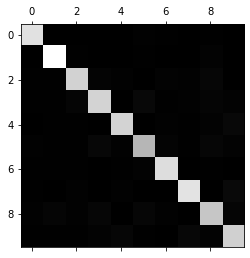

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다. 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데,

이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이 된다.

이번에는 에러를 살펴보자.

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_cnf_mx = conf_mx / row_sums

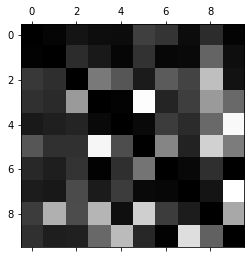

In [51]:
np.fill_diagonal(norm_cnf_mx, 0)
plt.matshow(norm_cnf_mx, cmap=plt.cm.gray)
plt.show() #큰 값은 흰색, 작은 값은 어두운 색

여기서 분류기가 만든 **에러를 확실히 볼 수 있다.** 행은 실제 클래스이고, 열은 예측한 클래스이다.

많은 이미지가 8과 9로 잘못 분류되었다는 것을 볼 수 있다. 또한 실제 8과 9도 다른 값으로 혼동이 자주 된다.

또한 에러는 정확하게 대칭이 아니다는 사실도 주목하자.

오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다. 3과 5가 서로 혼돈되는 것을 보완하고, 8과 9를 더 잘 분류할수 있도록 개선할 필요가 있다.

(예를 들어, 훈련 데이터를 더 모은다든가 하는 방식으로)

개개의 에러를 분석해보면 분류기가 무슨 일을 하고 있고, 왜 잘못되었는지에 대한 통찰을 얻을 수 있다.


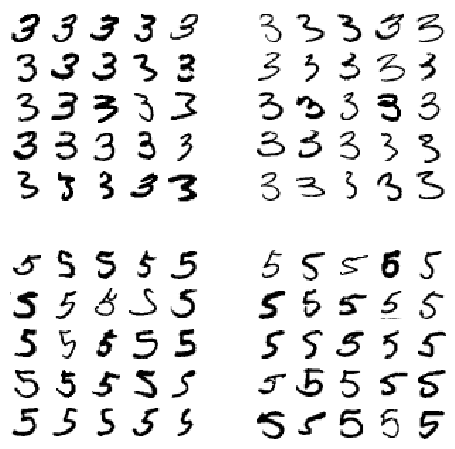

In [52]:
from uidam_package.plot import plot_digits

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

분류기가 실패한 원인은 선형 모델인 `SGDClassifier`를 사용했기 때문이다.

선형 분류기는 클래스마다 픽셀에 가중치를 할당하고, 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산한다.

따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 된다. 즉, 분류기는 이미지의 위치나 회전 방향에 매우 민감하기 때문에 

이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 방식이 도움이 될 수 있다.

# 3.6 다중 레이블 분류

지금까지는 각 샘플이 하나의 클래스에만 할당되었지만, 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있다.

예를 들어, 얼굴 인식의 경우 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었으면 분류기는 [1, 0, 1]을 출력해야 한다.

이렇게 여러 개의 이진 레이블을 출력하는 분류 시스템을 **다중 레이블 분류 Multilabel Classification** 시스템이라고 한다.

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [54]:
model_name = "chap3_knn_clf.pkl"

if(model.model_exists(model_name)):
    knn_clf = model.get_model(model_name)
else:
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_multilabel)
    model.save_model(knn_clf, model_name)
knn_clf

model loaded...


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 `y_multilabel` 배열을 만든다.

여기서 `KNeighborsClassifier`는 다중 레이블 분류를 지원하기 때문에 이 코드가 가능하다.

In [55]:
# 숫자 1은 크지 않고(False), 홀수(True)이다!
knn_clf.predict([X_train[0]])

array([[False, False]])

다중 레이블 분류기를 평가하는 방법은 많다.

예를 들어 각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산할 수 있다.

이 코드는 모든 레이블의 가중치가 같다고 가정했지만, 가중치를 개수로 주려면 `average="weighted"`를 설정하면 된다.

In [56]:
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 3.7 다중 출력 분류

마지막 분류 작업은 **다중 출력 다중 클래스 분류 Multioutput-Multiclass Classification** 또는 **다중 출력 분류 Multioutput Classification** 이다.

이는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.

이미지에서 노이즈를 제거하는 시스템을 떠올려보자. 노이즈가 많은 숫자 이미지를 입력으로 받고, 깨끗한 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력한다.

분류기의 출력이 다중 레이블 (픽셀당 한 레이블)이고, 각 레이블은 여러 개의 값을 가진다. (0-255)

그러므로 이 예는 다중 출력 분류 시스템이 된다.

먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 `randint()` 함수를 사용해 노이즈를 추가해보자.

In [57]:
import numpy.random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

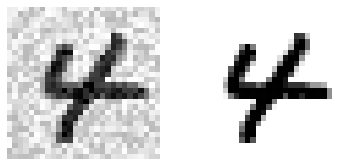

In [58]:
from uidam_package.plot import plot_digit

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

왼쪽이 노이즈, 오른쪽이 깨끗한 타겟 이미지이다. 

분류기를 훈련시켜 이 이미지를 깨끗하게 만들어보자.

model saved


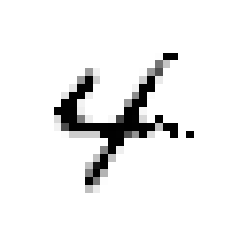

In [61]:
model_name = "chap3_knn_multi_clf.pkl"

if(model.model_exists(model_name)):
    digit_classifier = model.get_model(model_name)
else:
    digit_classifier = knn_clf.fit(X_train_mod, y_train_mod)
    model.save_model(digit_classifier, model_name)
    
clean_digit = digit_classifier.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

이제 분류에 대한 챕터가 끝났다! 

분류에서 좋은 측정 지표를 선택하고, 정밀도/재현율 트레이드오프를 고르고, 분류기를 비교하는 방법을 잘 활용해보자.